## 目录
1. SignalDigger是什么？
2. SignalDigger vs alphalens
3. 数据准备工作
4. 如何用SignalDigger测试和分析选股效果？
5. 选股效果可视化

##  SignalDigger是什么？
* SignalDigger是一个Python第三方库，专门用于选股因子alpha(α)的绩效分析。

* 它是alphalens的功能集成、简化版，针对A股市场交易制度（如涨跌停）专门进行了一些细节上的优化，适合初学者迅速掌握和使用

下载方式： pip install git+https://github.com/xingetouzi/JAQS.git@fxdayu

github地址： https://github.com/xingetouzi/JAQS/tree/fxdayu

官方网站：https://www.quantos.org/ 可登录该网站注册自己的数据账号

##  SignalDigger vs alphalens
![](./img/signaldiggervsalphalens___.png)

## 数据准备工作

下面以沪深300成分股为例，处理选股因子(signal_data)

In [1]:
from jaqs_fxdayu.data import DataView # 可以视为一个轻量级的数据库，数据格式基于pandas，方便数据的调用和处理
from jaqs_fxdayu.data import RemoteDataService # 数据服务，用于下载数据
import os
import warnings


warnings.filterwarnings("ignore")
dataview_folder = '../Factor'

if not (os.path.isdir(dataview_folder)):
    os.makedirs(dataview_folder)

D:\Anaconda3\lib\importlib\__init__.py:126: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _bootstrap._gcd_import(name[level:], package, level)


In [2]:
# 加载数据
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


* 以pb指标为例，测试pb的大小与沪深300成分股的涨跌关系
* 步骤：
  1、定义过滤条件-剔除非指数成分股
  2、确认是否能买入卖出（考虑停牌、涨跌停的限制）
  3、处理因子
  4、因子分析

In [3]:
print(dv.get_ts("pb").head())

symbol      000001.SZ  000002.SZ  000008.SZ  000009.SZ  000012.SZ  000024.SZ  \
trade_date                                                                     
20140102       1.0563     1.2891     4.8981     3.5794     2.3725     1.3202   
20140103       1.0304     1.2649     4.8709     3.4842     2.3346     1.2977   
20140106       1.0079     1.2068     4.6314     3.4537     2.2036     1.2283   
20140107       1.0044     1.1987     4.5661     3.4461     2.1920     1.2013   
20140108       1.0157     1.1971     4.4790     3.3852     2.1862     1.1685   

symbol      000027.SZ  000039.SZ  000046.SZ  000059.SZ    ...      601998.SH  \
trade_date                                                ...                  
20140102       0.9077     2.0483     2.4159     0.8806    ...         0.8216   
20140103       0.8861     2.0801     2.3726     0.8488    ...         0.8088   
20140106       0.8662     2.0113     2.3348     0.8081    ...         0.7960   
20140107       0.8629     2.0721     2.

In [4]:
import numpy as np

#定义信号过滤条件-非指数成分
def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = df_index_member == 0
    return mask_index_member

# 定义可买卖条件——未停牌、未涨跌停
def limit_up_down():
    trade_status = dv.get_ts('trade_status')
    mask_sus = trade_status == 0
    # 涨停
    dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False, add_data=True)
    # 跌停
    dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False, add_data=True)
    can_enter = np.logical_and(dv.get_ts('up_limit') < 1, ~mask_sus) # 未涨停未停牌
    can_exit = np.logical_and(dv.get_ts('down_limit') < 1, ~mask_sus) # 未跌停未停牌
    return can_enter,can_exit

mask = mask_index_member()
can_enter,can_exit = limit_up_down()

In [5]:
print(mask.head())
print(can_enter.head())

symbol      000001.SZ  000002.SZ  000008.SZ  000009.SZ  000012.SZ  000024.SZ  \
trade_date                                                                     
20140102        False      False       True      False      False      False   
20140103        False      False       True      False      False      False   
20140106        False      False       True      False      False      False   
20140107        False      False       True      False      False      False   
20140108        False      False       True      False      False      False   

symbol      000027.SZ  000039.SZ  000046.SZ  000059.SZ    ...      601998.SH  \
trade_date                                                ...                  
20140102         True      False      False       True    ...          False   
20140103         True      False      False       True    ...          False   
20140106         True      False      False       True    ...          False   
20140107         True      False      F

In [6]:
from jaqs_fxdayu.research import SignalDigger
obj = SignalDigger(output_folder='./output',
                   output_format='pdf')

# 处理因子 计算目标股票池每只股票的持有期收益，和对应因子值的quantile分类
obj.process_signal_before_analysis(signal=dv.get_ts("pb"),
                                   price=dv.get_ts("close_adj"),
                                   high=dv.get_ts("high_adj"), # 可为空
                                   low=dv.get_ts("low_adj"),# 可为空
                                   group=dv.get_ts("sw1"),# 可为空
                                   n_quantiles=5,# quantile分类数
                                   mask=mask,# 过滤条件
                                   can_enter=can_enter,# 是否能进场
                                   can_exit=can_exit,# 是否能出场
                                   period=15,# 持有期
                                   benchmark_price=dv.data_benchmark, # 基准价格 可不传入，持有期收益（return）计算为绝对收益
                                   commission = 0.0008,
                                   )
signal_data = obj.signal_data
signal_data.head()

Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%


signal    return  upside_ret  downside_ret  quantile  \
trade_date symbol                                                            
20140103   000001.SZ  1.0563 -0.003744    0.005068     -0.057799         5   
           000002.SZ  1.2891  0.012511    0.010680     -0.102841         2   
           000009.SZ  3.5794  0.029817    0.025430     -0.069652         4   
           000012.SZ  2.3725  0.021382    0.014163     -0.116760         4   
           000024.SZ  1.3202 -0.031632   -0.002781     -0.161771         3   

                     group  
trade_date symbol           
20140103   000001.SZ    银行  
           000002.SZ   房地产  
           000009.SZ    综合  
           000012.SZ  建筑材料  
           000024.SZ   房地产

## 因子分析

In [7]:
from jaqs_fxdayu.research.signaldigger.analysis import analysis
result = analysis(signal_data, is_event=False, period=15)

### 因子分析相关指标文档

#### 列项（ic类型/投资组合类型）:
* ic类:
  return_ic/upside_ret_ic/downside_ret_ic
  * 持有期收益的ic/持有期最大向上空间的ic/持有期最大向下空间的ic
* 持有收益类
  long_ret/short_ret/long_short_ret/top_quantile_ret/bottom_quantile_ret/tmb_ret/all_sample_ret
  * 多头组合收益/空头组合收益/多空组合收益/因子值最大组合收益/因子值最小组合收益/因子值最大组（构建多头）+因子值最小组（构建空头）收益/全样本（无论信号大小和方向）-基准组合收益
* 收益空间类
  long_space/short_space/long_short_space/top_quantile_space/bottom_quantile_space/tmb_space/all_sample_space
  * 多头组合空间/空头组合空间/多空组合空间/因子值最大组合空间/因子值最小组合空间/因子值最大组（构建多头）+因子值最小组（构建空头）空间/全样本（无论信号大小和方向）-基准组合空间

#### 索引项（ic或收益的具体指标）:
* ic类 
  "IC Mean", "IC Std.", "t-stat(IC)", "p-value(IC)", "IC Skew", "IC Kurtosis", "Ann. IR"
  * IC均值，IC标准差，IC的t统计量，对IC做0均值假设检验的p-value，IC偏度，IC峰度，iC的年化信息比率-mean/std
* 持有收益类 
  't-stat', "p-value", "skewness", "kurtosis", "Ann. Ret", "Ann. Vol", "Ann. IR", "occurance"
  * 持有期收益的t统计量，对持有期收益做0均值假设检验的p-value，偏度，峰度，持有期收益年化值，年化波动率，年化信息比率-年化收益/年化波动率，样本数量
* 收益空间类 
  'Up_sp Mean','Up_sp Std','Up_sp IR','Up_sp Pct5', 'Up_sp Pct25 ','Up_sp Pct50 ', 'Up_sp Pct75','Up_sp Pct95','Up_sp Occur','Down_sp Mean','Down_sp Std', 'Down_sp IR', 'Down_sp Pct5','Down_sp Pct25 ','Down_sp Pct50 ','Down_sp Pct75', 'Down_sp Pct95','Down_sp Occur'
  * 上行空间均值，上行空间标准差，上行空间信息比率-均值/标准差，上行空间5%分位数,..25%分位数，..中位数，..75%分位数,..95%分位数，上行空间样本数，
  * 下行..(同上)
    

In [8]:
print("——ic分析——")
print(result["ic"])
print("——选股收益分析——")
print(result["ret"])
print("——最大潜在盈利/亏损分析——")
print(result["space"])

——ic分析——
                return_ic  upside_ret_ic  downside_ret_ic
IC Mean     -6.945807e-02   5.937467e-02    -2.219792e-01
IC Std.      2.594710e-01   2.464900e-01     2.104796e-01
t-stat(IC)  -8.298423e+00   7.467299e+00    -3.269370e+01
p-value(IC)  3.549725e-16   1.835765e-13    3.604265e-158
IC Skew      5.251623e-02  -4.326744e-01     5.580971e-01
IC Kurtosis -7.602440e-01  -4.722475e-01     1.068205e-01
Ann. IR     -2.676911e-01   2.408806e-01    -1.054635e+00
——选股收益分析——
             long_ret  long_short_ret  top_quantile_ret  bottom_quantile_ret  \
t-stat      -4.354131       -6.429742        -17.141209            14.774824   
p-value      0.000010        0.000000          0.000000             0.000000   
skewness    -0.056936        0.043832          0.907698             1.758145   
kurtosis     2.476179        1.086328          5.921713            10.078364   
Ann. Ret    -0.074512       -0.093044         -0.123996             0.072271   
Ann. Vol     0.132007        0.11162

### 因子分析可视化

* 累计收益计算方法：将资金按持有天数等分，每天取一份买入所选股票-可以用该方式复制投资组合
* 相对收益计算方法：减去benchmark对应持有期的收益



Value of signals of Different Quantiles Statistics
             min        max      mean        std  count    count %
quantile                                                          
1         0.4286    19.3789  1.743018   0.949067  65862  24.422278
2         0.5307    14.6442  2.389186   1.263866  52990  19.649214
3         0.7358    21.6033  3.113060   1.765945  54424  20.180955
4         0.8013    36.3482  4.236022   2.608604  52990  19.649214
5         0.8848  5750.5164  7.938777  65.757157  43414  16.098339
Figure saved: E:\2019Course\QTC2019\QTC2019\newJaqs\output\returns_report.pdf
Information Analysis
                ic
IC Mean     -0.069
IC Std.      0.259
t-stat(IC)  -8.298
p-value(IC)  0.000
IC Skew      0.053
IC Kurtosis -0.760
Ann. IR     -0.268
Figure saved: E:\2019Course\QTC2019\QTC2019\newJaqs\output\information_report.pdf


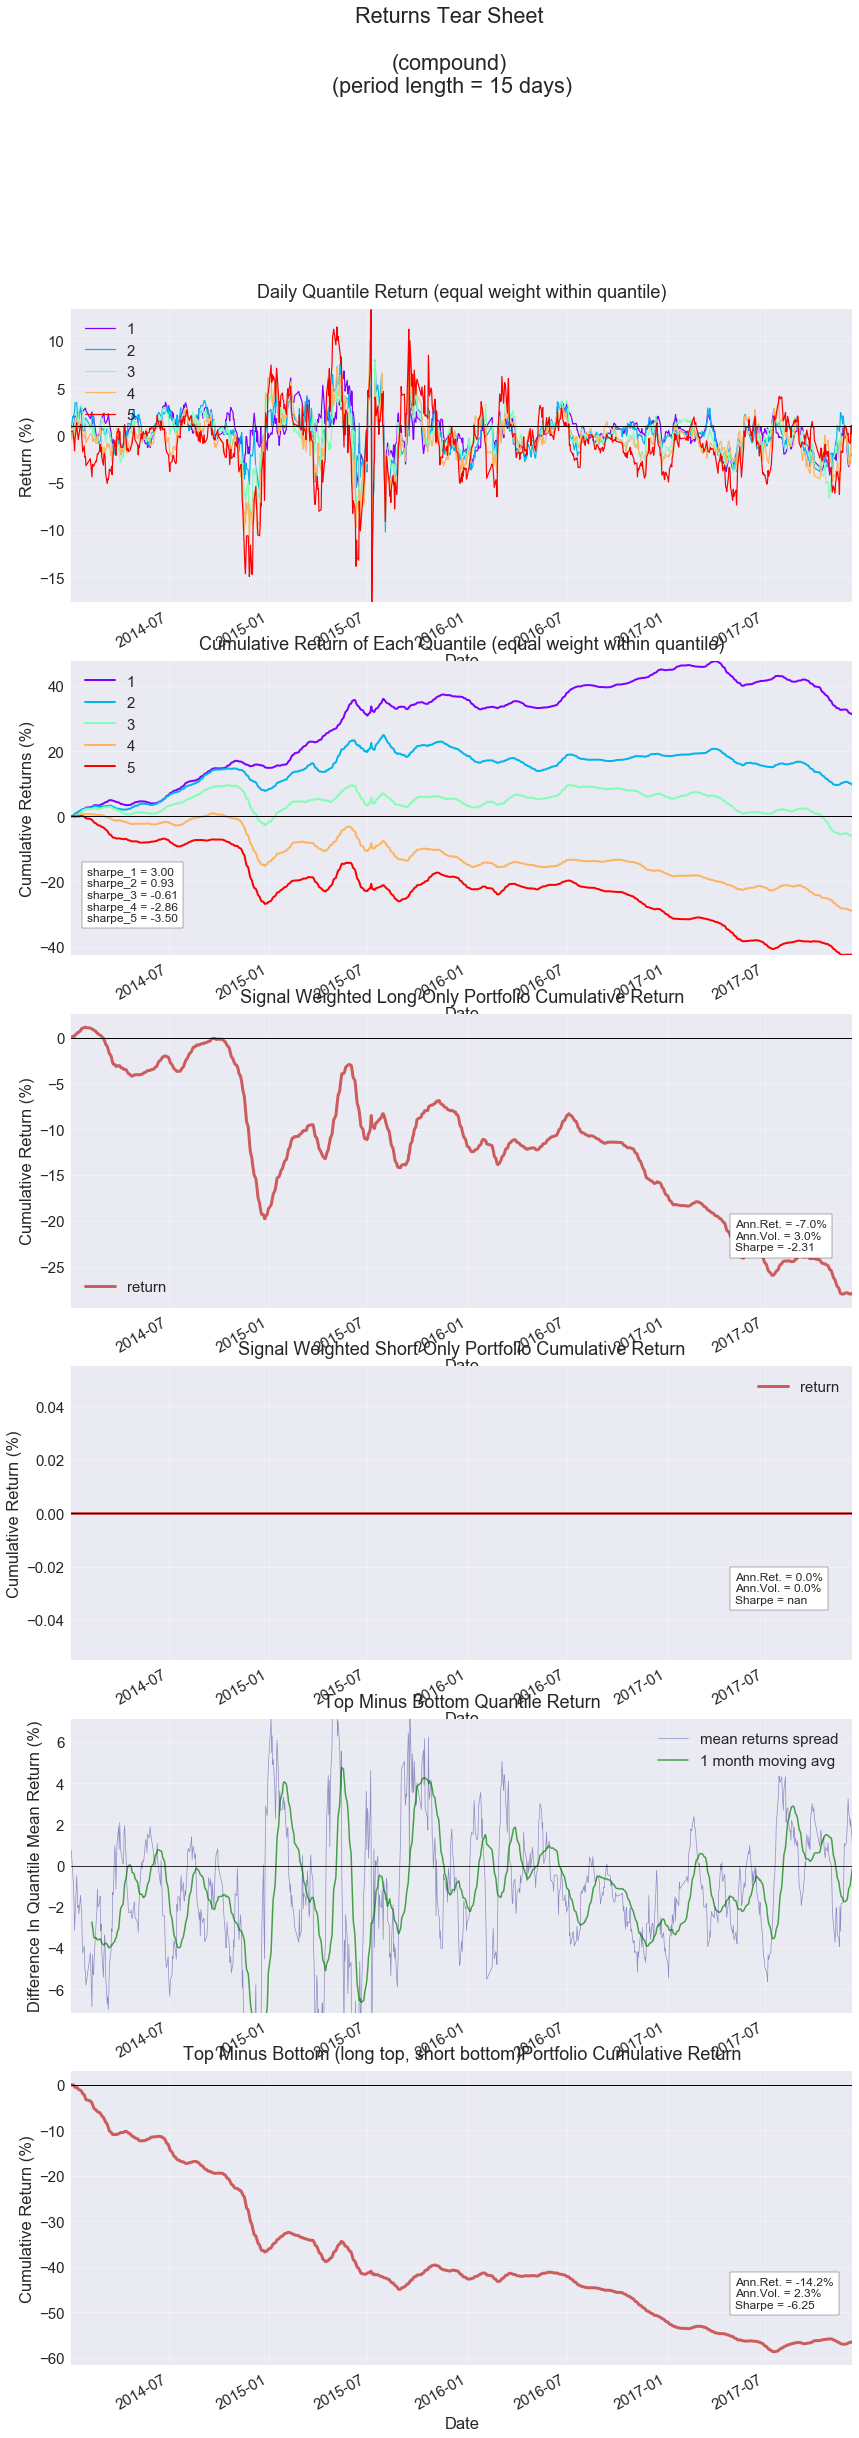

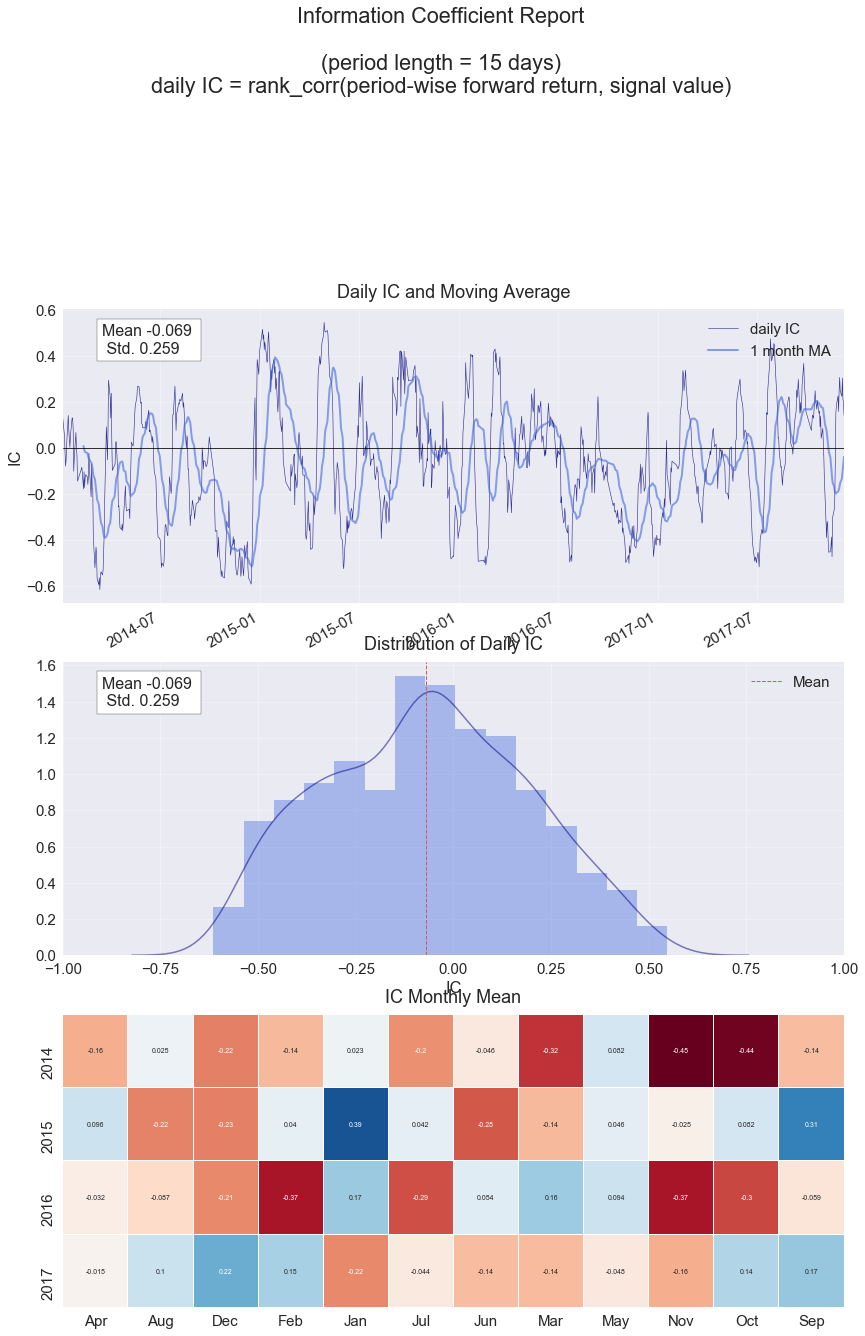

In [9]:
import matplotlib.pyplot as plt
obj.create_full_report()
plt.show()

In [10]:
# 分组分析
from jaqs_fxdayu.research.signaldigger import performance as pfm
ic = pfm.calc_signal_ic(signal_data, by_group=True)
mean_ic_by_group = pfm.mean_information_coefficient(ic, by_group=True)

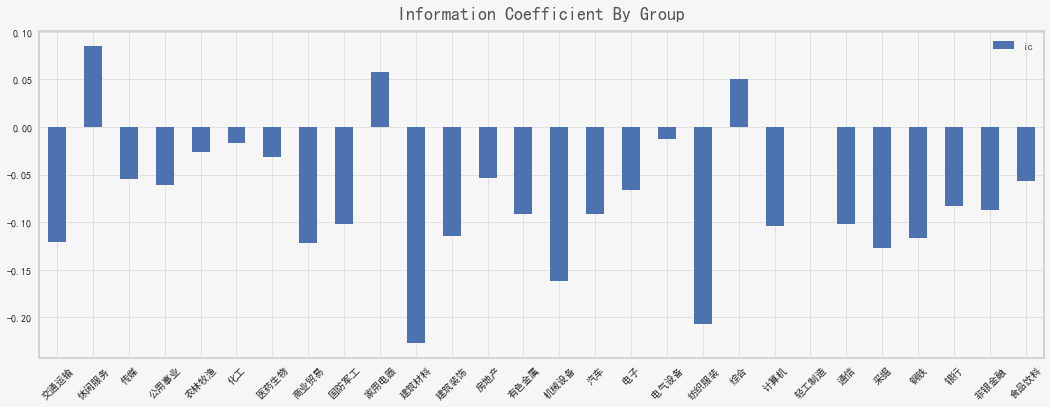

In [11]:
from jaqs_fxdayu.research.signaldigger import plotting

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plotting.plot_ic_by_group(mean_ic_by_group)
plt.show()

## 将Quantile1的选股结果保存成excel

In [12]:
excel_data = signal_data[signal_data['quantile']==1]["quantile"].unstack().replace(np.nan, 0)
print (excel_data.head())
excel_data.to_excel('./pb_quantile_1.xlsx')

symbol      000001.SZ  000002.SZ  000009.SZ  000024.SZ  000027.SZ  000039.SZ  \
trade_date                                                                     
20140103          0.0        0.0        0.0        0.0        0.0        0.0   
20140106          0.0        0.0        0.0        0.0        0.0        0.0   
20140107          0.0        0.0        0.0        0.0        0.0        0.0   
20140108          0.0        0.0        0.0        0.0        0.0        0.0   
20140109          0.0        0.0        0.0        0.0        0.0        0.0   

symbol      000063.SZ  000069.SZ  000100.SZ  000156.SZ    ...      601929.SH  \
trade_date                                                ...                  
20140103          0.0        0.0        1.0        0.0    ...            0.0   
20140106          0.0        0.0        1.0        0.0    ...            0.0   
20140107          0.0        0.0        0.0        0.0    ...            0.0   
20140108          0.0        0.0       